Notebook copied from /Users/fkutschera/Documents/Data/CRESCENT to https://github.com/fabian-kutschera/Benchmarks/tree/main for future reference.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Folder where the processed receivers will be saved
output_folder = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/"
# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Converting processes SeisSol fault rupture time data (after ParaView) 

1. Load fault-xdmf in ParaView
2. Go to last time step
3. Apply Cell Data to Point Data Filter
4. Select Save Data (_cplot_SeisSol.csv_)


In [3]:
df = pd.read_csv("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/tpv36_SCEC_v2_o4_David_RR/cplot_SeisSol.csv")
#df = pd.read_csv("/Users/fkutschera/Documents/Data/CRESCENT/tpv37_data/tpv37/cplot_SeisSol.csv")

# k: Distance down-dip (m)
# Positive means underground. 
# For TPV36 and TPV37, the value of k can range from 0 to 28000.
# Note: k is equal to depth value divided by the sine of 15 degrees.
df["k"] = abs(df["Points:2"] / np.sin(15*np.pi / 180))
print(np.min(df["k"]), np.max(df["k"]))
# j: Distance along strike (m)
df.rename({"RT": "t", "Points:0": "j"}, axis=1, inplace=True)
df = df.loc[:,["j", "k", "t"]] # re-order columns
df

21.806741454302006 27978.234743628123


,j,k,t
0,5928.9,1850.018417,7.2004
1,5928.9,1749.987138,7.2325
2,5900.1,1799.983459,7.2167
3,5842.3,1799.983459,7.2052
4,8671.4,1500.005534,7.7401
...,...,...,...
195139,8613.6,26399.911943,5.4080
195140,9104.4,26250.000255,5.5043
195141,9191.0,26200.158483,5.5187
195142,9133.2,26200.158483,5.5062


# Save data

In [4]:
# here: receiver refers to rupture times for the fault
tmp_receiver = os.path.join(output_folder, "tmp_receiver.csv")
df.to_csv(tmp_receiver, index=False, sep=" ", float_format="%.7e")
# choose name of final file
receiver = os.path.join(output_folder, "cplot.csv")

# Content with placeholders for the values

file_content = """# problem = tpv36 
# author = Fabian Kutschera
# date = 2024/10/05 
# code = SeisSol 
# code_version = v1.2.0
# element_size = 200.0 m (o4) 
# Column #1 = horizontal coordinate, distance along strike (m) 
# Column #2 = vertical coordinate, distance down-dip (m) 
# Column #3 = rupture time (s)
# 
# The line below lists the names of the data fields.
"""
    
# Format the string - nothing will be passes
formatted_content = file_content.format()

# Full path to the file
tmp_file = os.path.join(output_folder, "tmp.txt")

# Write the formatted content to the file
with open(tmp_file, 'w') as file:
    file.write(formatted_content)

In [5]:
!echo "$tmp_file" "$tmp_receiver" "$receiver"
!cat "$tmp_file" "$tmp_receiver" > "$receiver"
!rm "$tmp_file" "$tmp_receiver"

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_SCEC_v2_o4_David_RR/cplot.csv


# Plot final processes data

Checking if all sign conventions etc. are correct.

In [6]:
def cplot(df,points=1000,title='',save=False):
    '''
    Note: The nodes may appear in any order. The nodes do not have to form a rectangular grid, or any other regular pattern. 
    Note: When you upload a file, the server constructs the Delaunay triangulation of your nodes. 
        Then, it uses the Delaunay triangulation to interpolate the rupture times over the entire fault surface. 
        Finally, it uses the interpolated rupture times to draw a series of contour curves at intervals of 0.5 seconds.
    '''
    from scipy.interpolate import LinearNDInterpolator
    from scipy.spatial import Delaunay
    
    # Extract the j, k, and t values
    j = df['j'].values
    k = df['k'].values
    t = df['t'].values
    
    # Perform Delaunay triangulation on the coordinates (j, k)
    tri = Delaunay(np.array([j, k]).T)
    
    # Create an interpolator using the triangulation
    interp = LinearNDInterpolator(tri, t)
    
    # Define a grid of points over the (j, k) space for contour plotting
    points = 1000
    j_grid = np.linspace(j.min(), j.max(), points)
    k_grid = np.linspace(k.min(), k.max(), points)
    J, K = np.meshgrid(j_grid, k_grid)
    
    # Interpolate rupture time t over the grid
    T = interp(J, K)
    
    # Plot the contour
    plt.figure(figsize=(8, 6))
    print(np.max(t), np.max(T))
    #contour = plt.contour(J, K, T, levels=np.arange(0, np.ceil(np.max(T))+0.5, 0.5), cmap='viridis')
    contour = plt.contour(J, K, T, levels=np.arange(0, 10.5, 0.5), cmap='viridis')

    
    # Add labels to contour lines
    plt.clabel(contour, inline=True, fontsize=8)
    
    # Add labels and title
    plt.xlabel('Distance along strike [m]')
    plt.ylabel('distance down-dip [m]')
    plt.title('cplot (rupture contour plot) {}'.format(title))
    
    # Show color bar
    plt.colorbar(contour, label='Rupture time [s]')
    
    # Show the plot
    plt.ylim(28*1e3,0) # in meters
    if save == True:
        plt.savefig("rupture_time{}.png".format(title), dpi=300)
    plt.show()

## SeisSol

In [7]:
df = pd.read_csv(receiver, sep="\s+", comment="#")
df

,j,k,t
0,5928.9,1850.0184,7.2004
1,5928.9,1749.9871,7.2325
2,5900.1,1799.9835,7.2167
3,5842.3,1799.9835,7.2052
4,8671.4,1500.0055,7.7401
...,...,...,...
195139,8613.6,26399.9120,5.4080
195140,9104.4,26250.0000,5.5043
195141,9191.0,26200.1580,5.5187
195142,9133.2,26200.1580,5.5062


9.4888 nan


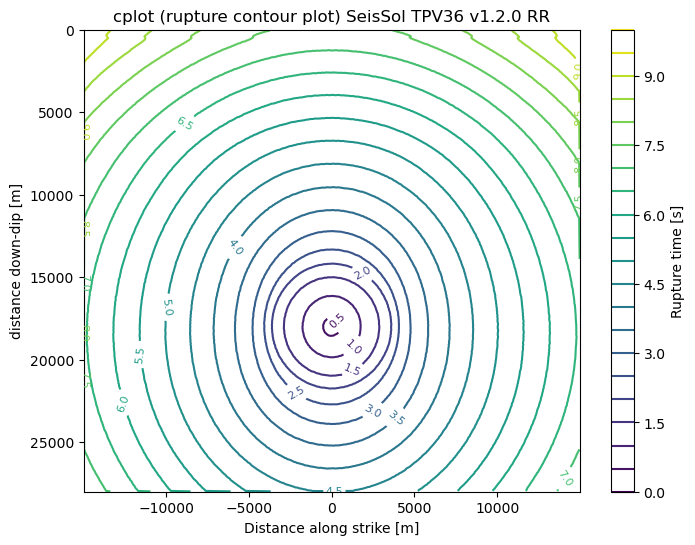

In [9]:
cplot(df, title="SeisSol TPV36 v1.2.0 RR", save=True)

## Barall

In [9]:
# Choose either
f_barall = pd.read_csv("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/cplot.csv", sep="\s+", comment="#")

9.576 9.576


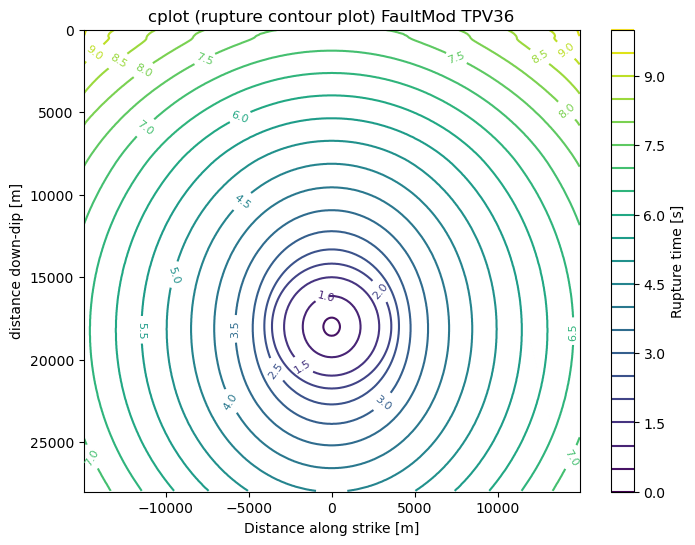

In [10]:
cplot(f_barall, title="FaultMod TPV36", save=False)